In [1]:
import torch
from spikingjelly.activation_based import layer, functional, neuron

T = 8
N = 1

def element_wise_add(x, y):
    return x + y

net = layer.ElementWiseRecurrentContainer(neuron.IFNode(), element_wise_add)
print(net)
x = torch.zeros([T, N])
x[0] = 1.5
for t in range(T):
    print(t, f'x[t]={x[t]}, s[t]={net(x[t])}')

functional.reset_net(net)

ElementWiseRecurrentContainer(
  element-wise function=<function element_wise_add at 0x000002114E2458A0>, step_mode=s
  (sub_module): IFNode(
    v_threshold=1.0, v_reset=0.0, detach_reset=False, step_mode=s, backend=torch
    (surrogate_function): Sigmoid(alpha=4.0, spiking=True)
  )
)
0 x[t]=tensor([1.5000]), s[t]=tensor([1.])
1 x[t]=tensor([0.]), s[t]=tensor([1.])
2 x[t]=tensor([0.]), s[t]=tensor([1.])
3 x[t]=tensor([0.]), s[t]=tensor([1.])
4 x[t]=tensor([0.]), s[t]=tensor([1.])
5 x[t]=tensor([0.]), s[t]=tensor([1.])
6 x[t]=tensor([0.]), s[t]=tensor([1.])
7 x[t]=tensor([0.]), s[t]=tensor([1.])


In [2]:
import torch
import torch.nn as nn
from spikingjelly.activation_based import layer, functional, neuron

stateful_conv = nn.Sequential(
    layer.Conv2d(3, 16, kernel_size=3, padding=1, stride=1),  # 理解为SNN中的突触
    layer.SynapseFilter(tau=100.)
)

In [34]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets
from spikingjelly.activation_based import neuron, surrogate, layer, functional
from torch.cuda import amp
import os, argparse
from torch.utils.tensorboard import SummaryWriter
import time
import datetime
import sys
from tqdm import tqdm

In [31]:
# 测试集评估函数
def evaluates3(name, model, data_loader, num_classes = 10):
    acc = 0
    losss = 0
    data_num = 0
    _ = model.eval()

    datas = tqdm(iter(data_loader),file=sys.stdout)
    with torch.no_grad():
        for data, targets in datas:
            data = data.to(device)
            targets = targets.to(device)
            # img.shape = [N, 1, H, W]
            data.squeeze_(1)  # [N, H, W]
            data = data.permute(2, 0, 1)  # [W, N, H]
            # we regard [W, N, H] as [T, N, H]
            
            label_onehot = F.one_hot(targets, num_classes).float()  # 将标签变为独热编码

            out_fr = model(data) # 将每次输出的脉冲进行相加

            loss = F.mse_loss(out_fr, label_onehot)
            data_num += targets.numel()
            losss += loss.item() * targets.numel()
            # 正确率的计算方法如下。认为输出层中脉冲发放频率最大的神经元的下标i是分类结果
            acc += (out_fr.argmax(1) == targets).float().sum().item()
            
            functional.reset_net(model)

#             del data, targets,loss
#             torch.cuda.empty_cache()
    
    print(f"{name} All Acc: {acc/data_num * 100:.2f}%")
    print(f"{name} All Loss: {losss/data_num:.4f}")
#     print("\n")
    return acc/data_num, losss/data_num

class PlainNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc = nn.Sequential(
            layer.Linear(28, 32),
            neuron.IFNode(surrogate_function=surrogate.ATan()),
            layer.Linear(32, 10),
            neuron.IFNode(surrogate_function=surrogate.ATan())
        )

    def forward(self, x: torch.Tensor):
        return self.fc(x).mean(0)

class StatefulSynapseNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc = nn.Sequential(
            layer.Linear(28, 32),
            neuron.IFNode(surrogate_function=surrogate.ATan()),
            layer.SynapseFilter(tau=2., learnable=True),
            layer.Linear(32, 10),
            neuron.IFNode(surrogate_function=surrogate.ATan())
        )

    def forward(self, x: torch.Tensor):
        return self.fc(x).mean(0)

class FeedBackNet(nn.Module):
    def __init__(self):
        super().__init__()

        self.fc = nn.Sequential(
            layer.Linear(28, 32),
            layer.LinearRecurrentContainer(
                neuron.IFNode(surrogate_function=surrogate.ATan(), detach_reset=True),
                in_features=32, out_features=32, bias=True
            ),
            layer.Linear(32, 10),
            neuron.IFNode(surrogate_function=surrogate.ATan())
        )

    def forward(self, x: torch.Tensor):
        return self.fc(x).mean(0)

In [38]:
root_dir = r'E:\mycode\jupyter\test_daily\data'
T = 4
batch_size = 512
lr = 1e-1
num_epochs = 20
num_workers = 0
num_classes = 10

train_set = torchvision.datasets.FashionMNIST(root=root_dir, train=True, transform=torchvision.transforms.ToTensor(), download=False)

test_set = torchvision.datasets.FashionMNIST(root=root_dir, train=False, transform=torchvision.transforms.ToTensor(), download=False)

train_loader = torch.utils.data.DataLoader(dataset=train_set, batch_size=batch_size, shuffle=True, drop_last=True, pin_memory=True)

test_loader = torch.utils.data.DataLoader(dataset=test_set, batch_size=batch_size, shuffle=True, drop_last=False, pin_memory=True)


# 设备选择使用GPU
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
# 初始化网络
# net = PlainNet().to(device)   
# net = StatefulSynapseNet().to(device)
net = FeedBackNet().to(device)

optimizer = torch.optim.Adam(net.parameters(), lr=lr)
# 学习率优化
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, num_epochs)
# scaler = None
scaler = amp.GradScaler()

train_accs = []
train_losss = []
test_accs = []
test_losss = []
best_acc = 0

In [39]:
for epoch in range(num_epochs):
    start_time = time.time()
    _ = net.train()
    train_loss = 0
    train_acc = 0
    train_samples = 0
    
    datas = tqdm(iter(train_loader),file=sys.stdout)
    for img, label in datas:
        optimizer.zero_grad()
        img = img.to(device)
        label = label.to(device)
        # img.shape = [N, 1, H, W]
        img.squeeze_(1)  # [N, H, W]
        img = img.permute(2, 0, 1)  # [W, N, H]
        # we regard [W, N, H] as [T, N, H]
        label_onehot = F.one_hot(label, num_classes).float()  # 将标签变为独热编码

        # 混合精度训练
        if scaler is not None:
            with amp.autocast():
                out_fr = net(img)
                loss = F.mse_loss(out_fr, label_onehot)
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
        else:
            out_fr = net(img)
            loss = F.mse_loss(out_fr, label_onehot)
            loss.backward()
            optimizer.step()

        train_samples += label.numel()
        train_loss += loss.item() * label.numel()
        # 正确率的计算方法如下。  认为输出层中脉冲发放频率最大的神经元的下标i是分类结果
        train_acc += (out_fr.argmax(1) == label).float().sum().item()
        # 优化一次参数后，需要重置网络的状态，因为SNN的神经元是有“记忆”的。
        functional.reset_net(net)
        
    lr_scheduler.step() # 学习率的优化
    end_time = time.time()
    print(f"epoch = {epoch}")
    print(f"train_single_time = {end_time - start_time:.4f}")
    print(f"loss = {train_loss/train_samples:.4f}")
    print(f"acc = {train_acc/train_samples*100:.2f}%")
    train_accs.append(train_acc/train_samples)
    train_losss.append(train_loss/train_samples)
    
    test_acc,test_loss = evaluates3("test", net, test_loader,num_classes)
    test_accs.append(test_acc)
    test_losss.append(test_loss)
    
    if test_acc > best_acc:
        best_acc = test_acc
        torch.save(net.state_dict(), 'save_model/CIFAR10_lr0.01_dp0.5_SEW18.pt')
        print("save model param")
    print(f'escape time = {(datetime.datetime.now() + datetime.timedelta(seconds=(time.time() - start_time) * (num_epochs - epoch - 1))).strftime("%Y-%m-%d %H:%M:%S")}\n')
    print("\n")  
    

100%|████████████████████████████████████████████████████████████████████████████████| 117/117 [00:10<00:00, 11.00it/s]
epoch = 0
train_single_time = 10.6367
loss = 0.1246
acc = 10.15%
100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 11.70it/s]
test All Acc: 10.02%
test All Loss: 0.1087
save model param
escape time = 2024-07-26 16:21:55



100%|████████████████████████████████████████████████████████████████████████████████| 117/117 [00:10<00:00, 10.92it/s]
epoch = 1
train_single_time = 10.7189
loss = 0.1272
acc = 11.26%
100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 11.63it/s]
test All Acc: 9.98%
test All Loss: 0.1500
escape time = 2024-07-26 16:21:56



100%|████████████████████████████████████████████████████████████████████████████████| 117/117 [00:10<00:00, 10.91it/s]
epoch = 2
train_single_time = 10.7434
loss = 0.1380
acc = 16.43%
100%|████████████████████████

In [40]:
root_dir = r'E:\mycode\jupyter\test_daily\data'
T = 4
batch_size = 512
lr = 1e-1
num_epochs = 20
num_workers = 0
num_classes = 10

train_set = torchvision.datasets.FashionMNIST(root=root_dir, train=True, transform=torchvision.transforms.ToTensor(), download=False)

test_set = torchvision.datasets.FashionMNIST(root=root_dir, train=False, transform=torchvision.transforms.ToTensor(), download=False)

train_loader = torch.utils.data.DataLoader(dataset=train_set, batch_size=batch_size, shuffle=True, drop_last=True, pin_memory=True)

test_loader = torch.utils.data.DataLoader(dataset=test_set, batch_size=batch_size, shuffle=True, drop_last=False, pin_memory=True)


# 设备选择使用GPU
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
# 初始化网络
# net = PlainNet().to(device)   
net = StatefulSynapseNet().to(device)
# net = FeedBackNet().to(device)

optimizer = torch.optim.Adam(net.parameters(), lr=lr)
# 学习率优化
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, num_epochs)
# scaler = None
scaler = amp.GradScaler()

train_accs2 = []
train_losss2 = []
test_accs2 = []
test_losss2 = []
best_acc2 = 0

In [41]:
for epoch in range(num_epochs):
    start_time = time.time()
    _ = net.train()
    train_loss = 0
    train_acc = 0
    train_samples = 0
    
    datas = tqdm(iter(train_loader),file=sys.stdout)
    for img, label in datas:
        optimizer.zero_grad()
        img = img.to(device)
        label = label.to(device)
        # img.shape = [N, 1, H, W]
        img.squeeze_(1)  # [N, H, W]
        img = img.permute(2, 0, 1)  # [W, N, H]
        # we regard [W, N, H] as [T, N, H]
        label_onehot = F.one_hot(label, num_classes).float()  # 将标签变为独热编码

        # 混合精度训练
        if scaler is not None:
            with amp.autocast():
                out_fr = net(img)
                loss = F.mse_loss(out_fr, label_onehot)
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
        else:
            out_fr = net(img)
            loss = F.mse_loss(out_fr, label_onehot)
            loss.backward()
            optimizer.step()

        train_samples += label.numel()
        train_loss += loss.item() * label.numel()
        # 正确率的计算方法如下。  认为输出层中脉冲发放频率最大的神经元的下标i是分类结果
        train_acc += (out_fr.argmax(1) == label).float().sum().item()
        # 优化一次参数后，需要重置网络的状态，因为SNN的神经元是有“记忆”的。
        functional.reset_net(net)
        
    lr_scheduler.step() # 学习率的优化
    end_time = time.time()
    print(f"epoch = {epoch}")
    print(f"train_single_time = {end_time - start_time:.4f}")
    print(f"loss = {train_loss/train_samples:.4f}")
    print(f"acc = {train_acc/train_samples*100:.2f}%")
    train_accs2.append(train_acc/train_samples)
    train_losss2.append(train_loss/train_samples)
    
    test_acc,test_loss = evaluates3("test", net, test_loader,num_classes)
    test_accs2.append(test_acc)
    test_losss2.append(test_loss)
    
    if test_acc > best_acc2:
        best_acc2 = test_acc
        torch.save(net.state_dict(), 'save_model/CIFAR10_lr0.01_dp0.5_SEW18.pt')
        print("save model param")
    print(f'escape time = {(datetime.datetime.now() + datetime.timedelta(seconds=(time.time() - start_time) * (num_epochs - epoch - 1))).strftime("%Y-%m-%d %H:%M:%S")}\n')
    print("\n")  
    

100%|████████████████████████████████████████████████████████████████████████████████| 117/117 [00:11<00:00,  9.94it/s]
epoch = 0
train_single_time = 11.7706
loss = 0.0949
acc = 28.45%
100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 10.66it/s]
test All Acc: 40.13%
test All Loss: 0.0780
save model param
escape time = 2024-07-26 16:26:30



100%|████████████████████████████████████████████████████████████████████████████████| 117/117 [00:10<00:00, 11.14it/s]
epoch = 1
train_single_time = 10.5025
loss = 0.0798
acc = 41.50%
100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 10.59it/s]
test All Acc: 44.22%
test All Loss: 0.0783
save model param
escape time = 2024-07-26 16:26:06



100%|████████████████████████████████████████████████████████████████████████████████| 117/117 [00:10<00:00, 10.93it/s]
epoch = 2
train_single_time = 10.7116
loss = 0.0726
acc = 48.24%
100%|██████

In [42]:
root_dir = r'E:\mycode\jupyter\test_daily\data'
T = 4
batch_size = 512
lr = 1e-1
num_epochs = 20
num_workers = 0
num_classes = 10

train_set = torchvision.datasets.FashionMNIST(root=root_dir, train=True, transform=torchvision.transforms.ToTensor(), download=False)

test_set = torchvision.datasets.FashionMNIST(root=root_dir, train=False, transform=torchvision.transforms.ToTensor(), download=False)

train_loader = torch.utils.data.DataLoader(dataset=train_set, batch_size=batch_size, shuffle=True, drop_last=True, pin_memory=True)

test_loader = torch.utils.data.DataLoader(dataset=test_set, batch_size=batch_size, shuffle=True, drop_last=False, pin_memory=True)


# 设备选择使用GPU
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
# 初始化网络
net = PlainNet().to(device)   
# net = StatefulSynapseNet().to(device)
# net = FeedBackNet().to(device)

optimizer = torch.optim.Adam(net.parameters(), lr=lr)
# 学习率优化
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, num_epochs)
# scaler = None
scaler = amp.GradScaler()

train_accs3 = []
train_losss3 = []
test_accs3 = []
test_losss3 = []
best_acc3 = 0

In [43]:
for epoch in range(num_epochs):
    start_time = time.time()
    _ = net.train()
    train_loss = 0
    train_acc = 0
    train_samples = 0
    
    datas = tqdm(iter(train_loader),file=sys.stdout)
    for img, label in datas:
        optimizer.zero_grad()
        img = img.to(device)
        label = label.to(device)
        # img.shape = [N, 1, H, W]
        img.squeeze_(1)  # [N, H, W]
        img = img.permute(2, 0, 1)  # [W, N, H]
        # we regard [W, N, H] as [T, N, H]
        label_onehot = F.one_hot(label, num_classes).float()  # 将标签变为独热编码

        # 混合精度训练
        if scaler is not None:
            with amp.autocast():
                out_fr = net(img)
                loss = F.mse_loss(out_fr, label_onehot)
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
        else:
            out_fr = net(img)
            loss = F.mse_loss(out_fr, label_onehot)
            loss.backward()
            optimizer.step()

        train_samples += label.numel()
        train_loss += loss.item() * label.numel()
        # 正确率的计算方法如下。  认为输出层中脉冲发放频率最大的神经元的下标i是分类结果
        train_acc += (out_fr.argmax(1) == label).float().sum().item()
        # 优化一次参数后，需要重置网络的状态，因为SNN的神经元是有“记忆”的。
        functional.reset_net(net)
        
    lr_scheduler.step() # 学习率的优化
    end_time = time.time()
    print(f"epoch = {epoch}")
    print(f"train_single_time = {end_time - start_time:.4f}")
    print(f"loss = {train_loss/train_samples:.4f}")
    print(f"acc = {train_acc/train_samples*100:.2f}%")
    train_accs3.append(train_acc/train_samples)
    train_losss3.append(train_loss/train_samples)
    
    test_acc,test_loss = evaluates3("test", net, test_loader,num_classes)
    test_accs3.append(test_acc)
    test_losss3.append(test_loss)
    
    if test_acc > best_acc3:
        best_acc3 = test_acc
        torch.save(net.state_dict(), 'save_model/CIFAR10_lr0.01_dp0.5_SEW18.pt')
        print("save model param")
    print(f'escape time = {(datetime.datetime.now() + datetime.timedelta(seconds=(time.time() - start_time) * (num_epochs - epoch - 1))).strftime("%Y-%m-%d %H:%M:%S")}\n')
    print("\n")  
    

100%|████████████████████████████████████████████████████████████████████████████████| 117/117 [00:10<00:00, 11.14it/s]
epoch = 0
train_single_time = 10.5056
loss = 0.0787
acc = 37.97%
100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 12.16it/s]
test All Acc: 37.50%
test All Loss: 0.0743
save model param
escape time = 2024-07-26 16:30:08



100%|████████████████████████████████████████████████████████████████████████████████| 117/117 [00:10<00:00, 10.72it/s]
epoch = 1
train_single_time = 10.9160
loss = 0.0698
acc = 48.51%
100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 11.99it/s]
test All Acc: 49.89%
test All Loss: 0.0649
save model param
escape time = 2024-07-26 16:30:16



100%|████████████████████████████████████████████████████████████████████████████████| 117/117 [00:10<00:00, 11.24it/s]
epoch = 2
train_single_time = 10.4166
loss = 0.0669
acc = 51.92%
100%|██████

In [45]:
import matplotlib.pyplot as plt

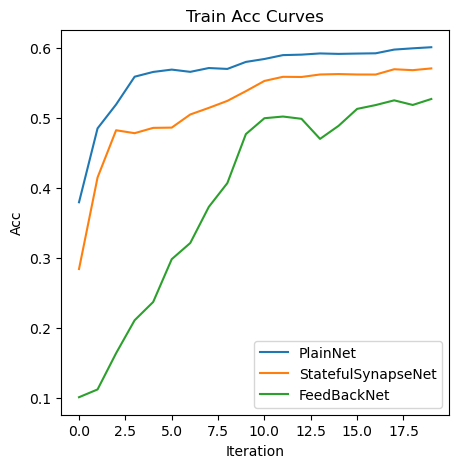

In [49]:
# Plot Loss
fig = plt.figure(facecolor="w", figsize=(5, 5))
plt.plot(train_accs3)
plt.plot(train_accs2)
plt.plot(train_accs)
plt.title("Train Acc Curves")
plt.legend(["PlainNet", "StatefulSynapseNet", "FeedBackNet"])
plt.xlabel("Iteration")
plt.ylabel("Acc")
plt.show()

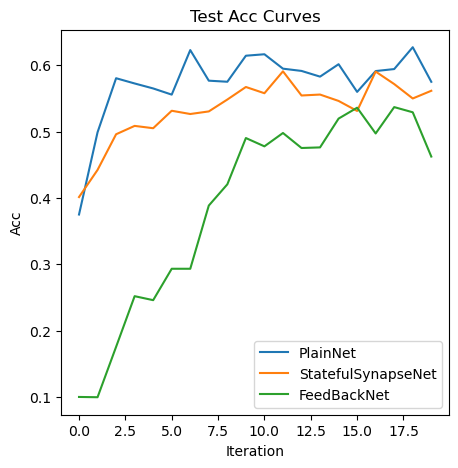

In [50]:
# Plot Loss
fig = plt.figure(facecolor="w", figsize=(5, 5))
plt.plot(test_accs3)
plt.plot(test_accs2)
plt.plot(test_accs)
plt.title("Test Acc Curves")
plt.legend(["PlainNet", "StatefulSynapseNet", "FeedBackNet"])
plt.xlabel("Iteration")
plt.ylabel("Acc")
plt.show()

In [53]:
root_dir = r'E:\mycode\jupyter\test_daily\data'
T = 4
batch_size = 512
lr = 1e-1
num_epochs = 20
num_workers = 0
num_classes = 10
momentum = 0.9

train_set = torchvision.datasets.FashionMNIST(root=root_dir, train=True, transform=torchvision.transforms.ToTensor(), download=False)

test_set = torchvision.datasets.FashionMNIST(root=root_dir, train=False, transform=torchvision.transforms.ToTensor(), download=False)

train_loader = torch.utils.data.DataLoader(dataset=train_set, batch_size=batch_size, shuffle=True, drop_last=True, pin_memory=True)

test_loader = torch.utils.data.DataLoader(dataset=test_set, batch_size=batch_size, shuffle=True, drop_last=False, pin_memory=True)


# 设备选择使用GPU
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
# 初始化网络
net = PlainNet().to(device)   
# net = StatefulSynapseNet().to(device)
# net = FeedBackNet().to(device)

# optimizer = torch.optim.Adam(net.parameters(), lr=lr)
optimizer = torch.optim.SGD(net.parameters(), lr=lr, momentum=momentum)
# 学习率优化
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, num_epochs)
# scaler = None
scaler = amp.GradScaler()

train_accs3 = []
train_losss3 = []
test_accs3 = []
test_losss3 = []
best_acc3 = 0

In [54]:
for epoch in range(num_epochs):
    start_time = time.time()
    _ = net.train()
    train_loss = 0
    train_acc = 0
    train_samples = 0
    
    datas = tqdm(iter(train_loader),file=sys.stdout)
    for img, label in datas:
        optimizer.zero_grad()
        img = img.to(device)
        label = label.to(device)
        # img.shape = [N, 1, H, W]
        img.squeeze_(1)  # [N, H, W]
        img = img.permute(2, 0, 1)  # [W, N, H]
        # we regard [W, N, H] as [T, N, H]
        label_onehot = F.one_hot(label, num_classes).float()  # 将标签变为独热编码

        # 混合精度训练
        if scaler is not None:
            with amp.autocast():
                out_fr = net(img)
                loss = F.mse_loss(out_fr, label_onehot)
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
        else:
            out_fr = net(img)
            loss = F.mse_loss(out_fr, label_onehot)
            loss.backward()
            optimizer.step()

        train_samples += label.numel()
        train_loss += loss.item() * label.numel()
        # 正确率的计算方法如下。  认为输出层中脉冲发放频率最大的神经元的下标i是分类结果
        train_acc += (out_fr.argmax(1) == label).float().sum().item()
        # 优化一次参数后，需要重置网络的状态，因为SNN的神经元是有“记忆”的。
        functional.reset_net(net)
        
    lr_scheduler.step() # 学习率的优化
    end_time = time.time()
    print(f"epoch = {epoch}")
    print(f"train_single_time = {end_time - start_time:.4f}")
    print(f"loss = {train_loss/train_samples:.4f}")
    print(f"acc = {train_acc/train_samples*100:.2f}%")
    train_accs3.append(train_acc/train_samples)
    train_losss3.append(train_loss/train_samples)
    
    test_acc,test_loss = evaluates3("test", net, test_loader,num_classes)
    test_accs3.append(test_acc)
    test_losss3.append(test_loss)
    
    if test_acc > best_acc3:
        best_acc3 = test_acc
        torch.save(net.state_dict(), 'save_model/CIFAR10_lr0.01_dp0.5_SEW18.pt')
        print("save model param")
    print(f'escape time = {(datetime.datetime.now() + datetime.timedelta(seconds=(time.time() - start_time) * (num_epochs - epoch - 1))).strftime("%Y-%m-%d %H:%M:%S")}\n')
    print("\n")  
    

100%|████████████████████████████████████████████████████████████████████████████████| 117/117 [00:10<00:00, 11.23it/s]
epoch = 0
train_single_time = 10.4198
loss = 0.1001
acc = 9.98%
100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 12.09it/s]
test All Acc: 10.48%
test All Loss: 0.1038
save model param
escape time = 2024-07-26 16:55:29



100%|████████████████████████████████████████████████████████████████████████████████| 117/117 [00:10<00:00, 11.21it/s]
epoch = 1
train_single_time = 10.4428
loss = 0.1018
acc = 15.15%
100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 12.06it/s]
test All Acc: 21.18%
test All Loss: 0.1152
save model param
escape time = 2024-07-26 16:55:29



100%|████████████████████████████████████████████████████████████████████████████████| 117/117 [00:10<00:00, 11.24it/s]
epoch = 2
train_single_time = 10.4068
loss = 0.1061
acc = 21.91%
100%|███████

In [55]:
root_dir = r'E:\mycode\jupyter\test_daily\data'
T = 4
batch_size = 512
lr = 1e-1
num_epochs = 20
num_workers = 0
num_classes = 10
momentum = 0.9

train_set = torchvision.datasets.FashionMNIST(root=root_dir, train=True, transform=torchvision.transforms.ToTensor(), download=False)

test_set = torchvision.datasets.FashionMNIST(root=root_dir, train=False, transform=torchvision.transforms.ToTensor(), download=False)

train_loader = torch.utils.data.DataLoader(dataset=train_set, batch_size=batch_size, shuffle=True, drop_last=True, pin_memory=True)

test_loader = torch.utils.data.DataLoader(dataset=test_set, batch_size=batch_size, shuffle=True, drop_last=False, pin_memory=True)


# 设备选择使用GPU
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
# 初始化网络
# net = PlainNet().to(device)   
net = StatefulSynapseNet().to(device)
# net = FeedBackNet().to(device)

# optimizer = torch.optim.Adam(net.parameters(), lr=lr)
optimizer = torch.optim.SGD(net.parameters(), lr=lr, momentum=momentum)
# 学习率优化
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, num_epochs)
# scaler = None
scaler = amp.GradScaler()

train_accs2 = []
train_losss2 = []
test_accs2 = []
test_losss2 = []
best_acc2 = 0

In [56]:
for epoch in range(num_epochs):
    start_time = time.time()
    _ = net.train()
    train_loss = 0
    train_acc = 0
    train_samples = 0
    
    datas = tqdm(iter(train_loader),file=sys.stdout)
    for img, label in datas:
        optimizer.zero_grad()
        img = img.to(device)
        label = label.to(device)
        # img.shape = [N, 1, H, W]
        img.squeeze_(1)  # [N, H, W]
        img = img.permute(2, 0, 1)  # [W, N, H]
        # we regard [W, N, H] as [T, N, H]
        label_onehot = F.one_hot(label, num_classes).float()  # 将标签变为独热编码

        # 混合精度训练
        if scaler is not None:
            with amp.autocast():
                out_fr = net(img)
                loss = F.mse_loss(out_fr, label_onehot)
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
        else:
            out_fr = net(img)
            loss = F.mse_loss(out_fr, label_onehot)
            loss.backward()
            optimizer.step()

        train_samples += label.numel()
        train_loss += loss.item() * label.numel()
        # 正确率的计算方法如下。  认为输出层中脉冲发放频率最大的神经元的下标i是分类结果
        train_acc += (out_fr.argmax(1) == label).float().sum().item()
        # 优化一次参数后，需要重置网络的状态，因为SNN的神经元是有“记忆”的。
        functional.reset_net(net)
        
    lr_scheduler.step() # 学习率的优化
    end_time = time.time()
    print(f"epoch = {epoch}")
    print(f"train_single_time = {end_time - start_time:.4f}")
    print(f"loss = {train_loss/train_samples:.4f}")
    print(f"acc = {train_acc/train_samples*100:.2f}%")
    train_accs2.append(train_acc/train_samples)
    train_losss2.append(train_loss/train_samples)
    
    test_acc,test_loss = evaluates3("test", net, test_loader,num_classes)
    test_accs2.append(test_acc)
    test_losss2.append(test_loss)
    
    if test_acc > best_acc2:
        best_acc2 = test_acc
        torch.save(net.state_dict(), 'save_model/CIFAR10_lr0.01_dp0.5_SEW18.pt')
        print("save model param")
    print(f'escape time = {(datetime.datetime.now() + datetime.timedelta(seconds=(time.time() - start_time) * (num_epochs - epoch - 1))).strftime("%Y-%m-%d %H:%M:%S")}\n')
    print("\n")  
    

100%|████████████████████████████████████████████████████████████████████████████████| 117/117 [00:10<00:00, 11.12it/s]
epoch = 0
train_single_time = 10.5286
loss = 0.1000
acc = 10.00%
100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 11.98it/s]
test All Acc: 10.00%
test All Loss: 0.1000
save model param
escape time = 2024-07-26 16:59:33



100%|████████████████████████████████████████████████████████████████████████████████| 117/117 [00:10<00:00, 11.11it/s]
epoch = 1
train_single_time = 10.5370
loss = 0.1097
acc = 11.40%
100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 12.08it/s]
test All Acc: 11.64%
test All Loss: 0.1311
save model param
escape time = 2024-07-26 16:59:33



100%|████████████████████████████████████████████████████████████████████████████████| 117/117 [00:10<00:00, 10.96it/s]
epoch = 2
train_single_time = 10.6950
loss = 0.1175
acc = 13.59%
100%|██████

In [57]:
root_dir = r'E:\mycode\jupyter\test_daily\data'
T = 4
batch_size = 512
lr = 1e-1
num_epochs = 20
num_workers = 0
num_classes = 10
momentum = 0.9

train_set = torchvision.datasets.FashionMNIST(root=root_dir, train=True, transform=torchvision.transforms.ToTensor(), download=False)

test_set = torchvision.datasets.FashionMNIST(root=root_dir, train=False, transform=torchvision.transforms.ToTensor(), download=False)

train_loader = torch.utils.data.DataLoader(dataset=train_set, batch_size=batch_size, shuffle=True, drop_last=True, pin_memory=True)

test_loader = torch.utils.data.DataLoader(dataset=test_set, batch_size=batch_size, shuffle=True, drop_last=False, pin_memory=True)


# 设备选择使用GPU
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
# 初始化网络
# net = PlainNet().to(device)   
# net = StatefulSynapseNet().to(device)
net = FeedBackNet().to(device)

# optimizer = torch.optim.Adam(net.parameters(), lr=lr)
optimizer = torch.optim.SGD(net.parameters(), lr=lr, momentum=momentum)
# 学习率优化
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, num_epochs)
# scaler = None
scaler = amp.GradScaler()

train_accs = []
train_losss = []
test_accs = []
test_losss = []
best_acc = 0

In [58]:
for epoch in range(num_epochs):
    start_time = time.time()
    _ = net.train()
    train_loss = 0
    train_acc = 0
    train_samples = 0
    
    datas = tqdm(iter(train_loader),file=sys.stdout)
    for img, label in datas:
        optimizer.zero_grad()
        img = img.to(device)
        label = label.to(device)
        # img.shape = [N, 1, H, W]
        img.squeeze_(1)  # [N, H, W]
        img = img.permute(2, 0, 1)  # [W, N, H]
        # we regard [W, N, H] as [T, N, H]
        label_onehot = F.one_hot(label, num_classes).float()  # 将标签变为独热编码

        # 混合精度训练
        if scaler is not None:
            with amp.autocast():
                out_fr = net(img)
                loss = F.mse_loss(out_fr, label_onehot)
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
        else:
            out_fr = net(img)
            loss = F.mse_loss(out_fr, label_onehot)
            loss.backward()
            optimizer.step()

        train_samples += label.numel()
        train_loss += loss.item() * label.numel()
        # 正确率的计算方法如下。  认为输出层中脉冲发放频率最大的神经元的下标i是分类结果
        train_acc += (out_fr.argmax(1) == label).float().sum().item()
        # 优化一次参数后，需要重置网络的状态，因为SNN的神经元是有“记忆”的。
        functional.reset_net(net)
        
    lr_scheduler.step() # 学习率的优化
    end_time = time.time()
    print(f"epoch = {epoch}")
    print(f"train_single_time = {end_time - start_time:.4f}")
    print(f"loss = {train_loss/train_samples:.4f}")
    print(f"acc = {train_acc/train_samples*100:.2f}%")
    train_accs.append(train_acc/train_samples)
    train_losss.append(train_loss/train_samples)
    
    test_acc,test_loss = evaluates3("test", net, test_loader,num_classes)
    test_accs.append(test_acc)
    test_losss.append(test_loss)
    
    if test_acc > best_acc:
        best_acc = test_acc
        torch.save(net.state_dict(), 'save_model/CIFAR10_lr0.01_dp0.5_SEW18.pt')
        print("save model param")
    print(f'escape time = {(datetime.datetime.now() + datetime.timedelta(seconds=(time.time() - start_time) * (num_epochs - epoch - 1))).strftime("%Y-%m-%d %H:%M:%S")}\n')
    print("\n")  
    

100%|████████████████████████████████████████████████████████████████████████████████| 117/117 [00:10<00:00, 10.96it/s]
epoch = 0
train_single_time = 10.6727
loss = 0.1000
acc = 10.00%
100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 11.74it/s]
test All Acc: 10.00%
test All Loss: 0.1000
save model param
escape time = 2024-07-26 17:03:41



100%|████████████████████████████████████████████████████████████████████████████████| 117/117 [00:10<00:00, 10.86it/s]
epoch = 1
train_single_time = 10.7726
loss = 0.1254
acc = 9.83%
100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 11.74it/s]
test All Acc: 41.96%
test All Loss: 0.0882
save model param
escape time = 2024-07-26 17:03:41



100%|████████████████████████████████████████████████████████████████████████████████| 117/117 [00:10<00:00, 11.02it/s]
epoch = 9
train_single_time = 10.6133
loss = 0.0855
acc = 36.09%
100%|███████

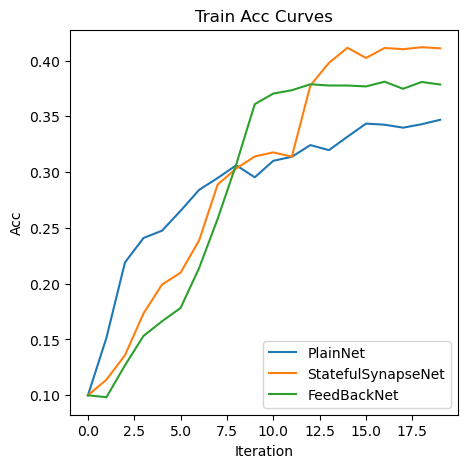

In [59]:
# Plot Loss
fig = plt.figure(facecolor="w", figsize=(5, 5))
plt.plot(train_accs3)
plt.plot(train_accs2)
plt.plot(train_accs)
plt.title("Train Acc Curves")
plt.legend(["PlainNet", "StatefulSynapseNet", "FeedBackNet"])
plt.xlabel("Iteration")
plt.ylabel("Acc")
plt.show()

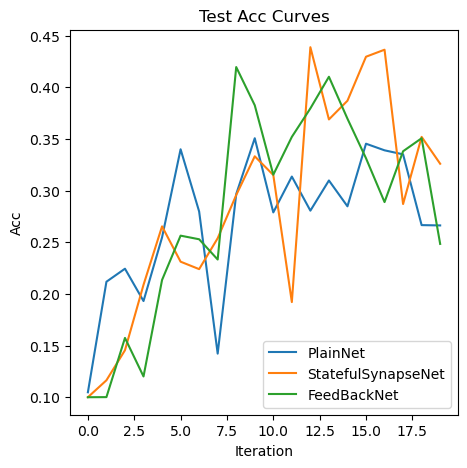

In [60]:
# Plot Loss
fig = plt.figure(facecolor="w", figsize=(5, 5))
plt.plot(test_accs3)
plt.plot(test_accs2)
plt.plot(test_accs)
plt.title("Test Acc Curves")
plt.legend(["PlainNet", "StatefulSynapseNet", "FeedBackNet"])
plt.xlabel("Iteration")
plt.ylabel("Acc")
plt.show()

In [63]:
root_dir = r'E:\mycode\jupyter\test_daily\data'
T = 4
batch_size = 128
lr = 1e-1
num_epochs = 20
num_workers = 0
num_classes = 10
momentum = 0.9

train_set = torchvision.datasets.FashionMNIST(root=root_dir, train=True, transform=torchvision.transforms.ToTensor(), download=False)

test_set = torchvision.datasets.FashionMNIST(root=root_dir, train=False, transform=torchvision.transforms.ToTensor(), download=False)

train_loader = torch.utils.data.DataLoader(dataset=train_set, batch_size=batch_size, shuffle=True, drop_last=True, pin_memory=True)

test_loader = torch.utils.data.DataLoader(dataset=test_set, batch_size=batch_size, shuffle=True, drop_last=False, pin_memory=True)


# 设备选择使用GPU
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
# 初始化网络
net = PlainNet().to(device)   
# net = StatefulSynapseNet().to(device)
# net = FeedBackNet().to(device)

# optimizer = torch.optim.Adam(net.parameters(), lr=lr)
optimizer = torch.optim.SGD(net.parameters(), lr=lr, momentum=momentum)
# 学习率优化
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, num_epochs)
# scaler = None
scaler = amp.GradScaler()

train_accs3 = []
train_losss3 = []
test_accs3 = []
test_losss3 = []
best_acc3 = 0

In [64]:
for epoch in range(num_epochs):
    start_time = time.time()
    _ = net.train()
    train_loss = 0
    train_acc = 0
    train_samples = 0
    
    datas = tqdm(iter(train_loader),file=sys.stdout)
    for img, label in datas:
        optimizer.zero_grad()
        img = img.to(device)
        label = label.to(device)
        # img.shape = [N, 1, H, W]
        img.squeeze_(1)  # [N, H, W]
        img = img.permute(2, 0, 1)  # [W, N, H]
        # we regard [W, N, H] as [T, N, H]
        label_onehot = F.one_hot(label, num_classes).float()  # 将标签变为独热编码

        # 混合精度训练
        if scaler is not None:
            with amp.autocast():
                out_fr = net(img)
                loss = F.mse_loss(out_fr, label_onehot)
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
        else:
            out_fr = net(img)
            loss = F.mse_loss(out_fr, label_onehot)
            loss.backward()
            optimizer.step()

        train_samples += label.numel()
        train_loss += loss.item() * label.numel()
        # 正确率的计算方法如下。  认为输出层中脉冲发放频率最大的神经元的下标i是分类结果
        train_acc += (out_fr.argmax(1) == label).float().sum().item()
        # 优化一次参数后，需要重置网络的状态，因为SNN的神经元是有“记忆”的。
        functional.reset_net(net)
        
    lr_scheduler.step() # 学习率的优化
    end_time = time.time()
    print(f"epoch = {epoch}")
    print(f"train_single_time = {end_time - start_time:.4f}")
    print(f"loss = {train_loss/train_samples:.4f}")
    print(f"acc = {train_acc/train_samples*100:.2f}%")
    train_accs3.append(train_acc/train_samples)
    train_losss3.append(train_loss/train_samples)
    
    test_acc,test_loss = evaluates3("test", net, test_loader,num_classes)
    test_accs3.append(test_acc)
    test_losss3.append(test_loss)
    
    if test_acc > best_acc3:
        best_acc3 = test_acc
        torch.save(net.state_dict(), 'save_model/CIFAR10_lr0.01_dp0.5_SEW18.pt')
        print("save model param")
    print(f'escape time = {(datetime.datetime.now() + datetime.timedelta(seconds=(time.time() - start_time) * (num_epochs - epoch - 1))).strftime("%Y-%m-%d %H:%M:%S")}\n')
    print("\n")  
    

100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:12<00:00, 37.29it/s]
epoch = 0
train_single_time = 12.5523
loss = 0.1081
acc = 15.59%
100%|██████████████████████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 45.01it/s]
test All Acc: 18.32%
test All Loss: 0.0939
save model param
escape time = 2024-07-26 17:13:46



100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:12<00:00, 37.44it/s]
epoch = 1
train_single_time = 12.5146
loss = 0.0945
acc = 28.99%
100%|██████████████████████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 42.94it/s]
test All Acc: 32.70%
test All Loss: 0.0839
save model param
escape time = 2024-07-26 17:13:47



100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:12<00:00, 37.48it/s]
epoch = 2
train_single_time = 12.4898
loss = 0.0823
acc = 38.20%
100%|██████

In [65]:
root_dir = r'E:\mycode\jupyter\test_daily\data'
T = 4
batch_size = 128
lr = 1e-1
num_epochs = 20
num_workers = 0
num_classes = 10
momentum = 0.9

train_set = torchvision.datasets.FashionMNIST(root=root_dir, train=True, transform=torchvision.transforms.ToTensor(), download=False)

test_set = torchvision.datasets.FashionMNIST(root=root_dir, train=False, transform=torchvision.transforms.ToTensor(), download=False)

train_loader = torch.utils.data.DataLoader(dataset=train_set, batch_size=batch_size, shuffle=True, drop_last=True, pin_memory=True)

test_loader = torch.utils.data.DataLoader(dataset=test_set, batch_size=batch_size, shuffle=True, drop_last=False, pin_memory=True)


# 设备选择使用GPU
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
# 初始化网络
# net = PlainNet().to(device)   
net = StatefulSynapseNet().to(device)
# net = FeedBackNet().to(device)

# optimizer = torch.optim.Adam(net.parameters(), lr=lr)
optimizer = torch.optim.SGD(net.parameters(), lr=lr, momentum=momentum)
# 学习率优化
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, num_epochs)
# scaler = None
scaler = amp.GradScaler()

train_accs2 = []
train_losss2 = []
test_accs2 = []
test_losss2 = []
best_acc2 = 0

In [66]:
for epoch in range(num_epochs):
    start_time = time.time()
    _ = net.train()
    train_loss = 0
    train_acc = 0
    train_samples = 0
    
    datas = tqdm(iter(train_loader),file=sys.stdout)
    for img, label in datas:
        optimizer.zero_grad()
        img = img.to(device)
        label = label.to(device)
        # img.shape = [N, 1, H, W]
        img.squeeze_(1)  # [N, H, W]
        img = img.permute(2, 0, 1)  # [W, N, H]
        # we regard [W, N, H] as [T, N, H]
        label_onehot = F.one_hot(label, num_classes).float()  # 将标签变为独热编码

        # 混合精度训练
        if scaler is not None:
            with amp.autocast():
                out_fr = net(img)
                loss = F.mse_loss(out_fr, label_onehot)
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
        else:
            out_fr = net(img)
            loss = F.mse_loss(out_fr, label_onehot)
            loss.backward()
            optimizer.step()

        train_samples += label.numel()
        train_loss += loss.item() * label.numel()
        # 正确率的计算方法如下。  认为输出层中脉冲发放频率最大的神经元的下标i是分类结果
        train_acc += (out_fr.argmax(1) == label).float().sum().item()
        # 优化一次参数后，需要重置网络的状态，因为SNN的神经元是有“记忆”的。
        functional.reset_net(net)
        
    lr_scheduler.step() # 学习率的优化
    end_time = time.time()
    print(f"epoch = {epoch}")
    print(f"train_single_time = {end_time - start_time:.4f}")
    print(f"loss = {train_loss/train_samples:.4f}")
    print(f"acc = {train_acc/train_samples*100:.2f}%")
    train_accs2.append(train_acc/train_samples)
    train_losss2.append(train_loss/train_samples)
    
    test_acc,test_loss = evaluates3("test", net, test_loader,num_classes)
    test_accs2.append(test_acc)
    test_losss2.append(test_loss)
    
    if test_acc > best_acc2:
        best_acc2 = test_acc
        torch.save(net.state_dict(), 'save_model/CIFAR10_lr0.01_dp0.5_SEW18.pt')
        print("save model param")
    print(f'escape time = {(datetime.datetime.now() + datetime.timedelta(seconds=(time.time() - start_time) * (num_epochs - epoch - 1))).strftime("%Y-%m-%d %H:%M:%S")}\n')
    print("\n")  
    

100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:13<00:00, 35.51it/s]
epoch = 0
train_single_time = 13.1828
loss = 0.1126
acc = 14.00%
100%|██████████████████████████████████████████████████████████████████████████████████| 79/79 [00:02<00:00, 38.49it/s]
test All Acc: 16.48%
test All Loss: 0.1646
save model param
escape time = 2024-07-26 17:18:49



100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:12<00:00, 36.85it/s]
epoch = 1
train_single_time = 12.7025
loss = 0.1044
acc = 25.47%
100%|██████████████████████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 43.78it/s]
test All Acc: 28.40%
test All Loss: 0.1050
save model param
escape time = 2024-07-26 17:18:35



100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:12<00:00, 36.24it/s]
epoch = 2
train_single_time = 12.9151
loss = 0.0922
acc = 30.07%
100%|██████

In [67]:
root_dir = r'E:\mycode\jupyter\test_daily\data'
T = 4
batch_size = 128
lr = 1e-1
num_epochs = 20
num_workers = 0
num_classes = 10
momentum = 0.9

train_set = torchvision.datasets.FashionMNIST(root=root_dir, train=True, transform=torchvision.transforms.ToTensor(), download=False)

test_set = torchvision.datasets.FashionMNIST(root=root_dir, train=False, transform=torchvision.transforms.ToTensor(), download=False)

train_loader = torch.utils.data.DataLoader(dataset=train_set, batch_size=batch_size, shuffle=True, drop_last=True, pin_memory=True)

test_loader = torch.utils.data.DataLoader(dataset=test_set, batch_size=batch_size, shuffle=True, drop_last=False, pin_memory=True)


# 设备选择使用GPU
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
# 初始化网络
# net = PlainNet().to(device)   
# net = StatefulSynapseNet().to(device)
net = FeedBackNet().to(device)

# optimizer = torch.optim.Adam(net.parameters(), lr=lr)
optimizer = torch.optim.SGD(net.parameters(), lr=lr, momentum=momentum)
# 学习率优化
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, num_epochs)
# scaler = None
scaler = amp.GradScaler()

train_accs = []
train_losss = []
test_accs = []
test_losss = []
best_acc = 0

In [68]:
for epoch in range(num_epochs):
    start_time = time.time()
    _ = net.train()
    train_loss = 0
    train_acc = 0
    train_samples = 0
    
    datas = tqdm(iter(train_loader),file=sys.stdout)
    for img, label in datas:
        optimizer.zero_grad()
        img = img.to(device)
        label = label.to(device)
        # img.shape = [N, 1, H, W]
        img.squeeze_(1)  # [N, H, W]
        img = img.permute(2, 0, 1)  # [W, N, H]
        # we regard [W, N, H] as [T, N, H]
        label_onehot = F.one_hot(label, num_classes).float()  # 将标签变为独热编码

        # 混合精度训练
        if scaler is not None:
            with amp.autocast():
                out_fr = net(img)
                loss = F.mse_loss(out_fr, label_onehot)
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
        else:
            out_fr = net(img)
            loss = F.mse_loss(out_fr, label_onehot)
            loss.backward()
            optimizer.step()

        train_samples += label.numel()
        train_loss += loss.item() * label.numel()
        # 正确率的计算方法如下。  认为输出层中脉冲发放频率最大的神经元的下标i是分类结果
        train_acc += (out_fr.argmax(1) == label).float().sum().item()
        # 优化一次参数后，需要重置网络的状态，因为SNN的神经元是有“记忆”的。
        functional.reset_net(net)
        
    lr_scheduler.step() # 学习率的优化
    end_time = time.time()
    print(f"epoch = {epoch}")
    print(f"train_single_time = {end_time - start_time:.4f}")
    print(f"loss = {train_loss/train_samples:.4f}")
    print(f"acc = {train_acc/train_samples*100:.2f}%")
    train_accs.append(train_acc/train_samples)
    train_losss.append(train_loss/train_samples)
    
    test_acc,test_loss = evaluates3("test", net, test_loader,num_classes)
    test_accs.append(test_acc)
    test_losss.append(test_loss)
    
    if test_acc > best_acc:
        best_acc = test_acc
        torch.save(net.state_dict(), 'save_model/CIFAR10_lr0.01_dp0.5_SEW18.pt')
        print("save model param")
    print(f'escape time = {(datetime.datetime.now() + datetime.timedelta(seconds=(time.time() - start_time) * (num_epochs - epoch - 1))).strftime("%Y-%m-%d %H:%M:%S")}\n')
    print("\n")  
    

100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:13<00:00, 35.24it/s]
epoch = 0
train_single_time = 13.2848
loss = 0.1304
acc = 10.45%
100%|██████████████████████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 41.90it/s]
test All Acc: 15.87%
test All Loss: 0.0991
save model param
escape time = 2024-07-26 17:23:39



100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:13<00:00, 35.94it/s]
epoch = 1
train_single_time = 13.0227
loss = 0.1036
acc = 25.58%
100%|██████████████████████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 41.98it/s]
test All Acc: 34.12%
test All Loss: 0.0837
save model param
escape time = 2024-07-26 17:23:34



100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:13<00:00, 35.82it/s]
epoch = 2
train_single_time = 13.0817
loss = 0.0865
acc = 35.21%
100%|██████

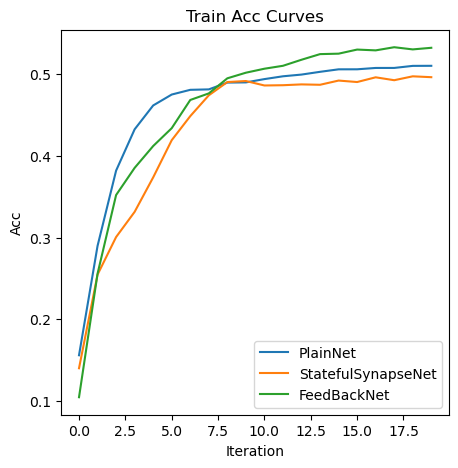

In [69]:
# Plot Loss
fig = plt.figure(facecolor="w", figsize=(5, 5))
plt.plot(train_accs3)
plt.plot(train_accs2)
plt.plot(train_accs)
plt.title("Train Acc Curves")
plt.legend(["PlainNet", "StatefulSynapseNet", "FeedBackNet"])
plt.xlabel("Iteration")
plt.ylabel("Acc")
plt.show()

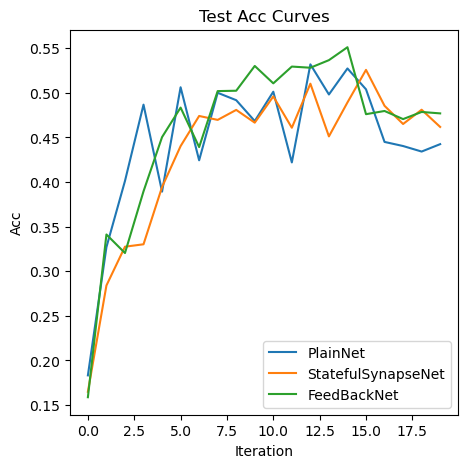

In [70]:
# Plot Loss
fig = plt.figure(facecolor="w", figsize=(5, 5))
plt.plot(test_accs3)
plt.plot(test_accs2)
plt.plot(test_accs)
plt.title("Test Acc Curves")
plt.legend(["PlainNet", "StatefulSynapseNet", "FeedBackNet"])
plt.xlabel("Iteration")
plt.ylabel("Acc")
plt.show()